# Imports / Settings

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.display import display
import ipywidgets as widgets

from pathlib import Path


import os
import glob
import calendar

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Global Variables

In [3]:
cols = {
    'ccn':['Date','Time','Protocol','Count','Mystery Variable'],
    'occ':['Date', 'OCC Type', 'Server Name', 'Server Code', 'Diameter Type', 'Protocol', 'Traffic']
}

In [4]:
has_Date = {'ccn':False, 'occ':['Date']}

In [5]:
delimiters = {'ccn':r'\s+', 'occ':None}

In [6]:
path_ccn = './CCN_OCC_Stats_File/CCN/'

In [7]:
path_occ = './CCN_OCC_Stats_File/OCC/'

In [8]:
path_roaming = './roaming_data/ROAMING_DATA_FEB_MAR_APR_MAY2020.xlsx'

In [9]:
int_to_month_mappper = {k: v for k,v in enumerate(calendar.month_abbr)}

In [10]:
dtypes = {
    'ccn':{'Date':'int32', 'Time':'object', 'Protocol':'object', 'Count':'int64', 'Mystery Variable':'float64'},
    'occ':{'Date':'object', 'OCC Type':'object', 'Server Name':'object', 'Server Code':'object' ,'Diameter Type':'object', 'Protocol':'object' ,'Traffic':'int64'}
}

In [11]:
protocols = {
    'Voice':['Voice-Charging-FirstInterrogation-Successful', 'Voice-Charging-IntermediateInterrogation-Successful' ,'Voice-Charging-FinalReport-Successful'],
    'Sms':['Messaging-Charging-Originating-Sms'],
    'Data':['Diameter Front-End.Gy-CCR-Initial.request', 'Diameter Front-End.Gy-CCR-Update.request' ,'Diameter Front-End.Gy-CCR-Termination.request']}

In [12]:
unit_roaming = {
    'Mobile originated Call':'seconds', 
    'Mobile Terminating Call':'seconds',
    'Short Message Originating Call': 'Count', 
    'GPRS':'GB\'s'
}

dividers_roaming = {
    'GB\'s':1024*1024*1024,
    'seconds':1,
    'Count':1
}

# Driver Function(s)

## Helper Functions

### Colour the Dataframe

In [13]:
# def colour_ge_value(value, comparison):
#     if value >= comparison:
#         return 'color: red'
#     else:
#         return 'color: black'

### Display Dataframe

In [14]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

### Retrieve Data

In [15]:
def getFrame(path:'path_to_files', type_data=None) -> 'pd.DataFrame':
    
    if(not (type_data.lower()=='ccn' or type_data.lower()=='occ')):
        raise Exception(f'\x1b[31m\n OOPS!! {type_data} is not a valid type of data \n\x1b[0m')
    
    all_files = glob.glob(path + "*.gz")
    
    li_dfs = []
    for filename in all_files:
        df_all = pd.read_csv(filename, index_col=None, compression='gzip', header=None, 
                             delimiter=delimiters[type_data],
                             names=cols[type_data],
                             dtype=dtypes[type_data],
                             parse_dates=has_Date[type_data])
        if(type_data.lower()=='ccn'):
            df_all['CCN Type'] = str(filename[52:56])
            df_all['CCN Type'].astype('object')
        li_dfs.append(df_all)
        
    frame = pd.concat(li_dfs, axis=0, ignore_index=True)
    return frame

### Split Date

In [16]:
def split_date_ccn(df:'dataframe') -> 'pd.DataFrame':
    df['Year'] = df.apply(lambda row: map_dates_to_year(row.Date), axis = 1)
    df['Month'] = df.apply(lambda row: map_dates_to_month(row.Date), axis = 1)
    df['Day'] = df.apply(lambda row: map_dates_to_day(row.Date), axis = 1)
    
    df.drop('Date', inplace=True, axis=1)
    return df

In [17]:
def split_date_occ(df:'dataframe') -> 'pd.DataFrame':
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['Hour'] = df.Date.dt.hour
    df['Minute'] = df.Date.dt.minute
    df['Second'] = df.Date.dt.second
    
    df.drop('Date', inplace=True, axis=1)
    return df

### Split Time

In [18]:
def split_time_ccn(df:'ccn_frame') ->'pd.Dataframe':
    df['Hour'] = df.apply(lambda row: map_time_to_hour(row.Time), axis = 1)
    df['Minute'] = df.apply(lambda row: map_time_to_minute(row.Time), axis = 1)
    
    df.drop('Time', inplace=True, axis=1)
    return df

### Groupby Occ

In [19]:
def get_occ(type_occ):
    global occ_frame
    occ = occ_frame.loc[(occ_frame['OCC Type']==type_occ)]
    occ.reset_index(drop=True, inplace=True)
    
    occ = occ.loc[occ.Protocol.isin(protocols['Data']), 
                  ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Protocol', 'Traffic']]
    return occ

### Create Raw File

In [20]:
def create_file(name):
    os.makedirs('tmp', exist_ok=True)
    if(name.upper()=='CCN'):
        ccn_frame.to_feather(f'tmp/{name.upper()}-raw')
    if(name.upper()=='OCC'):
        occ_frame.to_feather(f'tmp/{name.upper()}-raw')

### Deals with Resets

In [21]:
def add_resests(inc_list) -> 'List(Non-Inc Traffic)':
    index=0
    resets_occ=[]
    while(index<len(inc_list)-1):
        if(inc_list[index]>inc_list[index+1]):
            resets_occ.append(index+1)
        index = index + 1
    
    for reset_index in resets_occ:
        adder = inc_list[reset_index - 1] - inc_list[reset_index]
        index=reset_index
        while(index<len(inc_list)):
            inc_list[index] = inc_list[index] + adder
            index = index + 1      
    
    non_inc_occ = [0,]
    index = 1
    while(index < len(inc_list)):
        non_inc_occ.append(inc_list[index] - inc_list[index-1])
        index = index + 1
    
    return non_inc_occ

In [22]:
def sum_all(l1, l2, l3, l4):
    i = 0
    all_occs_list=[]
    while(i<len(l1)):
        all_occs_list.append(l1[i] + l2[i] + l3[i] + l4[i])
        i = i + 1
        
    return all_occs_list

### Checks if file exists

In [23]:
def exists(path):
    return Path(path).is_file()

## Mappers for CCN

### Date Mappers

In [24]:
def map_dates_to_month(date:'date of int type as yyyymmdd') -> 'int(Month)':
    month = (date//100)%100
    if ((month<1) or (month>12)): raise Exception(f'\x1b[31m\n OOPS!! The date({date}) is not in range \n\x1b[0m')
    return month

In [25]:
def map_dates_to_year(date:'date of int type as yyyymmdd') ->'int(Year)':
    try: year = date//10000
    except: raise Exception(f'\x1b[31m\n OOPS!! The date({date}) is not in range \n\x1b[0m')
    return year

In [26]:
def map_dates_to_day(date:'date of int type as yyyymmdd') -> 'int(Day)':
    day = date%100 
    if ((day<1) or (day>31)): raise Exception(f'\x1b[31m\n OOPS!! The date({date}) is not in range \n\x1b[0m') 
    return day

### Time Mappers

In [27]:
def map_time_to_hour(time:'time of object type as hh:mm') -> 'int(hh)':
    try:
        return int(time[:2])
    except:
        raise Exception(f'\x1b[31m\n OOPS!! The time({time}) is not in range \n\x1b[0m')

In [28]:
def map_time_to_minute(time:'time of object type as hh:mm') -> 'int(hh)':
    try:
        return int(time[3:])
    except:
        raise Exception(f'\x1b[31m\n OOPS!! The time({time}) is not in range \n\x1b[0m')

## Preparing The Dataframes

In [29]:
def prepare_dfs():
    global ccn_frame
    if(exists('tmp/CCN-raw')):
        ccn_frame = pd.read_feather('tmp/CCN-raw')
    else:
        ccn_frame = getFrame(path=path_ccn, type_data='ccn')
        ccn_frame = split_date_ccn(ccn_frame)
        ccn_frame = split_time_ccn(ccn_frame)
        create_file('ccn')
    
    global occ_frame
    if(exists('tmp/OCC-raw')):
        occ_frame = pd.read_feather('tmp/OCC-raw')
    else:
        occ_frame = getFrame(path=path_occ, type_data='occ')
        occ_frame = split_date_occ(occ_frame)
        create_file('occ')

## Filtering CCN

In [30]:
def filter_ccn(type_ccn, type_service):
    global ccn_frame
    if(not type_ccn=='ALL_CCN'):
        filtered_frame = ccn_frame.loc[ccn_frame['CCN Type']==type_ccn]
    else:
        filtered_frame = ccn_frame.copy()
        
    filtered_frame = filtered_frame.sort_values(by=['Year', 'Month', 'Day'])
    filtered_frame.reset_index(drop=True, inplace=True)
    filtered_frame = filtered_frame.loc[filtered_frame.Protocol.isin(protocols[type_service]), 
                                        ['Year', 'Month', 'Day', 'Protocol', 'Count']]
    filtered_frame = filtered_frame.groupby(['Year', 'Month', 'Day']).sum()
    return filtered_frame

## Filtering OCC

In [31]:
def filter_occ(type_occ):
    global occ_frame
    occ1 = get_occ('occ1')
    occ2 = get_occ('occ2')
    occ3 = get_occ('occ3')
    occ4 = get_occ('occ4')
    
    occ1 = occ1.groupby(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']).sum()
    occ2 = occ2.groupby(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']).sum()
    occ3 = occ3.groupby(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']).sum()
    occ4 = occ4.groupby(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']).sum()
    
    occ1_traffic_list = add_resests(occ1['Traffic'].tolist().copy())
    occ2_traffic_list = add_resests(occ2['Traffic'].tolist().copy())
    occ3_traffic_list = add_resests(occ3['Traffic'].tolist().copy())
    occ4_traffic_list = add_resests(occ4['Traffic'].tolist().copy())
    
    occ1_frame = pd.DataFrame(occ1_traffic_list, index=occ1.index.copy(), columns=['Traffic'])
    occ2_frame = pd.DataFrame(occ2_traffic_list, index=occ2.index.copy(), columns=['Traffic'])
    occ3_frame = pd.DataFrame(occ3_traffic_list, index=occ3.index.copy(), columns=['Traffic'])
    occ4_frame = pd.DataFrame(occ4_traffic_list, index=occ4.index.copy(), columns=['Traffic'])
    
    occ1_frame = occ1_frame.groupby(['Year', 'Month', 'Day']).sum()
    occ2_frame = occ2_frame.groupby(['Year', 'Month', 'Day']).sum()
    occ3_frame = occ3_frame.groupby(['Year', 'Month', 'Day']).sum()
    occ4_frame = occ4_frame.groupby(['Year', 'Month', 'Day']).sum()
    
    if(type_occ.lower()=='occ1'):
        return occ1_frame
    elif(type_occ.lower()=='occ2'):
        return occ2_frame
    elif(type_occ.lower()=='occ3'):
        return occ3_frame
    elif(type_occ.lower()=='occ4'):
        return occ4_frame
    elif(type_occ=='ALL_OCC'):
        occ1_list = occ1_frame['Traffic'].tolist()
        occ2_list = occ2_frame['Traffic'].tolist()
        occ3_list = occ3_frame['Traffic'].tolist()
        occ4_list = occ4_frame['Traffic'].tolist()
        all_occ_list = sum_all(occ1_list, occ2_list, occ3_list, occ4_list)
        all_occ_frame = pd.DataFrame(all_occ_list, index=occ1_frame.index.copy(), columns=['Traffic'])
        return all_occ_frame

# Main

In [32]:
prepare_dfs()

# Removing Missing Data

>We are removing the CCN Data before 17th March and after 1st June because some of the ccns server had data missing in them

In [33]:
ccn_frame = ccn_frame.loc[~((ccn_frame.Year==2020) & (ccn_frame.Month==3) & (ccn_frame.Day<=16) | (ccn_frame.Year==2020) & (ccn_frame.Month==6) & (ccn_frame.Day==1))]

# Dashboard

## Dashboard Settings

In [34]:
output = widgets.Output()
plot_output1 = widgets.Output()
plot_output2 = widgets.Output()

dropdown_service = widgets.Dropdown(options =['Voice', 'Sms', 'Data'], description='Type of Service')
dropdown_ccn_occ = widgets.Dropdown(options =['ALL', 'OCC1','OCC2','OCC3','OCC4','CCN4','CCN5','CCN6','CCN7'],
                                    description='Type CCN')

def common_filtering(service, node):
    output.clear_output()
    plot_output1.clear_output()
    plot_output2.clear_output()
    
    if (service == 'Voice') & (node == 'ALL'):
        common_filter = filter_ccn(type_ccn='ALL_CCN', type_service='Voice')
    elif (service == 'Voice') & (node == 'CCN4'):
        common_filter = filter_ccn(type_ccn='CCN4', type_service='Voice')
    elif (service == 'Voice') & (node == 'CCN5'):
        common_filter = filter_ccn(type_ccn='CCN5', type_service='Voice')
    elif (service == 'Voice') & (node == 'CCN6'):
        common_filter = filter_ccn(type_ccn='CCN6', type_service='Voice')
    elif (service == 'Voice') & (node == 'CCN7'):
        common_filter = filter_ccn(type_ccn='CCN7', type_service='Voice')
        

    elif (service == 'Sms') & (node == 'ALL'):
        common_filter = filter_ccn(type_ccn='ALL_CCN', type_service='Sms')
    elif (service == 'Sms') & (node == 'CCN4'):
        common_filter = filter_ccn(type_ccn='CCN4', type_service='Sms')
    elif (service == 'Sms') & (node == 'CCN5'):
        common_filter = filter_ccn(type_ccn='CCN5', type_service='Sms')
    elif (service == 'Sms') & (node == 'CCN6'):
        common_filter = filter_ccn(type_ccn='CCN6', type_service='Sms')
    elif (service == 'Sms') & (node == 'CCN7'):
        common_filter = filter_ccn(type_ccn='CCN7', type_service='Sms')
        
        
    elif (service == 'Data') & (node == 'ALL'):
        common_filter = filter_occ(type_occ='ALL_OCC')
    elif (service == 'Data') & (node == 'OCC1'):
        common_filter = filter_occ(type_occ='OCC1')
    elif (service == 'Data') & (node == 'OCC2'):
        common_filter = filter_occ(type_occ='OCC2')
    elif (service == 'Data') & (node == 'OCC3'):
        common_filter = filter_occ(type_occ='OCC3')
    elif (service == 'Data') & (node == 'OCC4'):
        common_filter = filter_occ(type_occ='OCC4')
        
    
    with output:
        try:
            display(common_filter) 
        except:
            print('Not a valid choice')
        
    with plot_output1:
        try:
            common_filter.plot(use_index=True, figsize=(20, 6))
            plt.suptitle(service + ' ' + node)
            plt.xlabel('Dates')
            plt.ylabel('Traffic')
            plt.tight_layout()
            plt.savefig(f"{service}_{node}_lineplot", dpi=100)
            plt.show()
        except Exception as e:
            print(f'{e}')
            print('Not a valid choice')
    
    with plot_output2:
        try:
            common_filter.plot.bar(use_index=True, figsize=(20, 6))
            plt.suptitle(service + ' ' + node)
            plt.xlabel('Dates')
            plt.ylabel('Traffic')
            plt.tight_layout()
            plt.savefig(f"{service}_{node}_barplot", dpi=100)
            plt.show()
        except Exception as e:
            print(f'{e}')
            print('Not a valid choice')

### Event Handlers

In [35]:
def dropdown_service_eventhandler(change):
    common_filtering(change.new, dropdown_ccn_occ.value)
    
def dropdown_ccn_occ_eventhandler(change):
    common_filtering(dropdown_service.value, change.new)
    
dropdown_service.observe(dropdown_service_eventhandler, names='value')
dropdown_ccn_occ.observe(dropdown_ccn_occ_eventhandler, names='value')

In [36]:
item_layout = widgets.Layout(margin='10px 0 30px 0') # u r d l
input_widgets = widgets.HBox([dropdown_service, dropdown_ccn_occ],layout=item_layout)
tab = widgets.Tab([output, plot_output1,plot_output2],layout=item_layout)
tab.set_title(0, 'Dataset Exploration')
tab.set_title(1, 'Line Plot')
tab.set_title(2, 'Bar Plot')
dashboard = widgets.VBox([input_widgets, tab])

## Display

In [37]:
display(dashboard)

# Busiest Hour

## CCN(Voice)

In [38]:
df_ccn = pd.read_feather('tmp/CCN-raw')

In [39]:
df_ccn = df_ccn.loc[df_ccn.Protocol.isin(protocols['Voice']), ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Protocol', 'Count']]
df_ccn.sort_values(by=['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)
df_ccn.reset_index(drop=True, inplace=True)

In [40]:
df_3_voice = df_ccn.loc[(df_ccn['Month']==3)]
df_4_voice = df_ccn.loc[(df_ccn['Month']==4)]
df_5_voice = df_ccn.loc[(df_ccn['Month']==5)]
df_3_4_5_voice = df_ccn.loc[~(df_ccn['Month']==6)]

In [41]:
df_3_voice = df_3_voice[['Hour', 'Count']]
df_3_voice = df_3_voice.groupby(['Hour']).sum()
df_3_voice[['Count']].idxmax() 

Count    10
dtype: int64

In [42]:
df_4_voice = df_4_voice[['Hour', 'Count']]
df_4_voice = df_4_voice.groupby(['Hour']).sum()
df_4_voice[['Count']].idxmax() 

Count    10
dtype: int64

In [43]:
df_5_voice = df_5_voice[['Hour', 'Count']]
df_5_voice = df_5_voice.groupby(['Hour']).sum()
df_5_voice[['Count']].idxmax() 

Count    10
dtype: int64

In [44]:
df_3_4_5_voice = df_3_4_5_voice[['Hour', 'Count']]
df_3_4_5_voice = df_3_4_5_voice.groupby(['Hour']).sum()
df_3_4_5_voice[['Count']].idxmax() 

Count    10
dtype: int64

## CCN(Sms)

In [45]:
df_ccn = pd.read_feather('tmp/CCN-raw')

In [46]:
df_ccn = df_ccn.loc[df_ccn.Protocol.isin(protocols['Sms']), ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Protocol', 'Count']]
df_ccn.sort_values(by=['Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)
df_ccn.reset_index(drop=True, inplace=True)

In [47]:
df_3_sms = df_ccn.loc[(df_ccn['Month']==3)]
df_4_sms = df_ccn.loc[(df_ccn['Month']==4)]
df_5_sms = df_ccn.loc[(df_ccn['Month']==5)]
df_3_4_5_sms = df_ccn.loc[~(df_ccn['Month']==6)]

In [48]:
df_3_sms = df_3_sms[['Hour', 'Count']]
df_3_sms = df_3_sms.groupby(['Hour']).sum()
df_3_sms[['Count']].idxmax() 

Count    21
dtype: int64

In [49]:
df_4_sms = df_4_sms[['Hour', 'Count']]
df_4_sms = df_4_sms.groupby(['Hour']).sum()
df_4_sms[['Count']].idxmax() 

Count    21
dtype: int64

In [50]:
df_5_sms = df_5_sms[['Hour', 'Count']]
df_5_sms = df_5_sms.groupby(['Hour']).sum()
df_5_sms[['Count']].idxmax() 

Count    22
dtype: int64

In [51]:
df_3_4_5_sms = df_3_4_5_sms[['Hour', 'Count']]
df_3_4_5_sms = df_3_4_5_sms.groupby(['Hour']).sum()
df_3_4_5_sms[['Count']].idxmax() 

Count    21
dtype: int64

## OCC(Data)

In [52]:
def filter_occ_again_oof(month):
    global occ_frame
    
    df_occ = occ_frame.copy()
    if(not month=='ALL'): df_occ = df_occ.loc[df_occ.Month==month]
    else: df_occ = df_occ.loc[~(df_occ.Month==6)]     
        
    occ1 = df_occ.loc[(df_occ['OCC Type']=='occ1')]
    occ2 = df_occ.loc[(df_occ['OCC Type']=='occ2')]
    occ3 = df_occ.loc[(df_occ['OCC Type']=='occ3')]
    occ4 = df_occ.loc[(df_occ['OCC Type']=='occ4')]
    
    occ1.reset_index(drop=True, inplace=True)
    occ2.reset_index(drop=True, inplace=True)
    occ3.reset_index(drop=True, inplace=True)
    occ4.reset_index(drop=True, inplace=True)
    
    occ1 = occ1.loc[occ1.Protocol.isin(protocols['Data']), ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Protocol', 'Traffic']]
    occ2 = occ2.loc[occ2.Protocol.isin(protocols['Data']), ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Protocol', 'Traffic']]
    occ3 = occ3.loc[occ3.Protocol.isin(protocols['Data']), ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Protocol', 'Traffic']]
    occ4 = occ4.loc[occ4.Protocol.isin(protocols['Data']), ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Protocol', 'Traffic']]
    
    
    occ1 = occ1.groupby(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']).sum()
    occ2 = occ2.groupby(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']).sum()
    occ3 = occ3.groupby(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']).sum()
    occ4 = occ4.groupby(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']).sum()
    
    occ1_traffic_list = add_resests(occ1['Traffic'].tolist().copy())
    occ2_traffic_list = add_resests(occ2['Traffic'].tolist().copy())
    occ3_traffic_list = add_resests(occ3['Traffic'].tolist().copy())
    occ4_traffic_list = add_resests(occ4['Traffic'].tolist().copy())
    
    occ1_frame = pd.DataFrame(occ1_traffic_list, index=occ1.index.copy(), columns=['Traffic'])
    occ2_frame = pd.DataFrame(occ2_traffic_list, index=occ2.index.copy(), columns=['Traffic'])
    occ3_frame = pd.DataFrame(occ3_traffic_list, index=occ3.index.copy(), columns=['Traffic'])
    occ4_frame = pd.DataFrame(occ4_traffic_list, index=occ4.index.copy(), columns=['Traffic'])
    
    occ1_frame = occ1_frame.groupby(['Year', 'Month', 'Day', 'Hour']).sum()
    occ2_frame = occ2_frame.groupby(['Year', 'Month', 'Day', 'Hour']).sum()
    occ3_frame = occ3_frame.groupby(['Year', 'Month', 'Day', 'Hour']).sum()
    occ4_frame = occ4_frame.groupby(['Year', 'Month', 'Day', 'Hour']).sum()
    
    occ1_list = occ1_frame['Traffic'].tolist()
    occ2_list = occ2_frame['Traffic'].tolist()
    occ3_list = occ3_frame['Traffic'].tolist()
    occ4_list = occ4_frame['Traffic'].tolist()
    all_occ_list = sum_all(occ1_list, occ2_list, occ3_list, occ4_list)
    all_occ_frame = pd.DataFrame(all_occ_list, index=occ1_frame.index.copy(), columns=['Traffic'])
    return all_occ_frame

In [53]:
df_3_data = filter_occ_again_oof(3)
df_4_data = filter_occ_again_oof(4)
df_5_data = filter_occ_again_oof(5)
df_all_data = filter_occ_again_oof('ALL')

In [54]:
df_3_data.reset_index(inplace=True)
df_3_data = df_3_data[['Hour', 'Traffic']]
df_3_data = df_3_data.groupby(['Hour']).sum()
df_3_data[['Traffic']].idxmax()

Traffic    20
dtype: int64

In [55]:
df_4_data.reset_index(inplace=True)
df_4_data = df_4_data[['Hour', 'Traffic']]
df_4_data = df_4_data.groupby(['Hour']).sum()
df_4_data[['Traffic']].idxmax()

Traffic    21
dtype: int64

In [56]:
df_5_data.reset_index(inplace=True)
df_5_data = df_5_data[['Hour', 'Traffic']]
df_5_data = df_5_data.groupby(['Hour']).sum()
df_5_data[['Traffic']].idxmax()

Traffic    21
dtype: int64

In [57]:
df_all_data.reset_index(inplace=True)
df_all_data = df_all_data[['Hour', 'Traffic']]
df_all_data = df_all_data.groupby(['Hour']).sum()
df_all_data[['Traffic']].idxmax()

Traffic    21
dtype: int64

# Analysis on Roaming

In [58]:
dict_roaming = pd.read_excel(path_roaming, sheet_name='Sheet1')

In [59]:
df_roaming = pd.DataFrame(dict_roaming, columns=['TRANSDATE', 'CALLTYPE', 'CALL TYPE DESCRIPTION', 'VOLUME', 'CDR COUNT'])

In [60]:
df_roaming.sort_values(by=['TRANSDATE'], inplace=True)
df_roaming.reset_index(drop=True, inplace=True)

In [61]:
def filter_roaming(call_type:'string') ->'pd.DataFrame':
    filtered_frame = df_roaming.loc[df_roaming['CALL TYPE DESCRIPTION'].isin([call_type]), ['TRANSDATE', 'VOLUME']]
    filtered_frame['TRANSDATE'] = filtered_frame['TRANSDATE'].dt.strftime('%Y-%m-%d')
    filtered_frame['VOLUME'] = filtered_frame['VOLUME']/dividers_roaming[unit_roaming[call_type]]
    filtered_frame.reset_index(drop=True, inplace=True)
    return filtered_frame

In [62]:
def plot_roaming(call_type):
    filter_roaming(call_type).plot.bar(x='TRANSDATE', y='VOLUME', figsize=(25, 10));
    plt.xlabel('Dates')
    plt.ylabel(f'Volume ({unit_roaming[call_type]})')
    plt.title(call_type)
    plt.show()

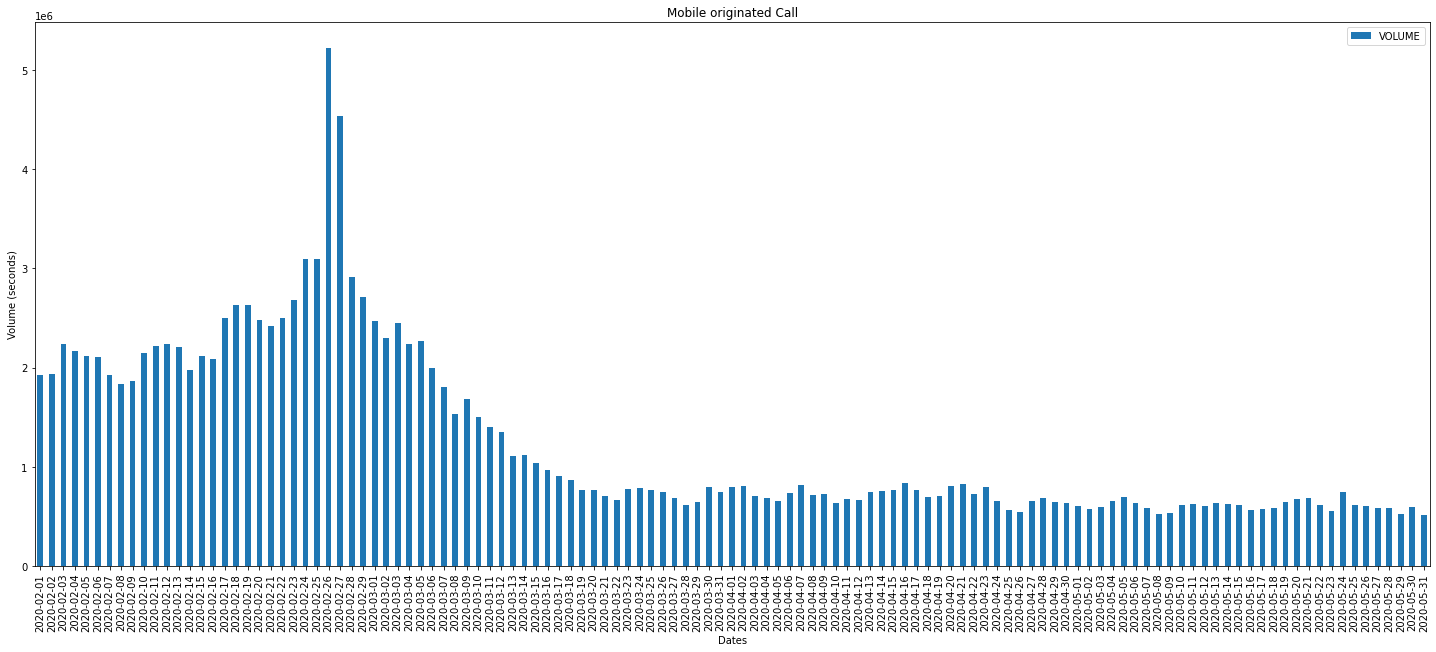

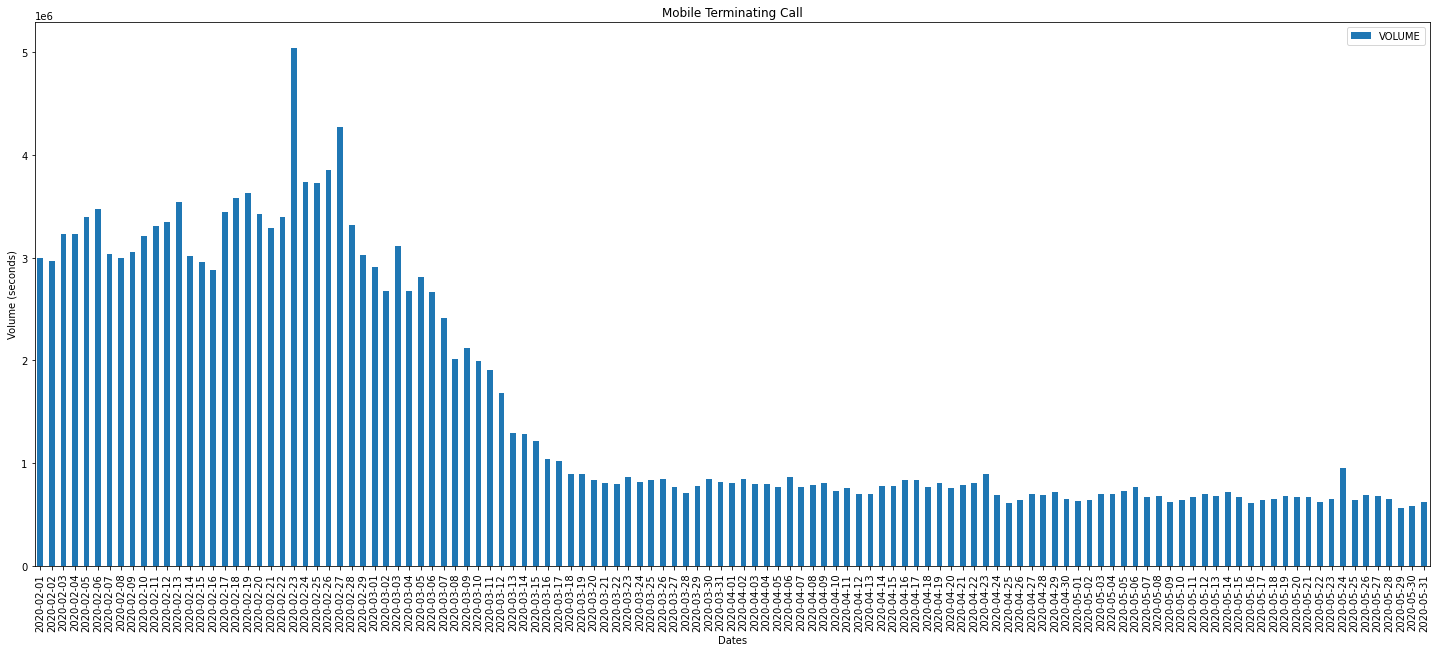

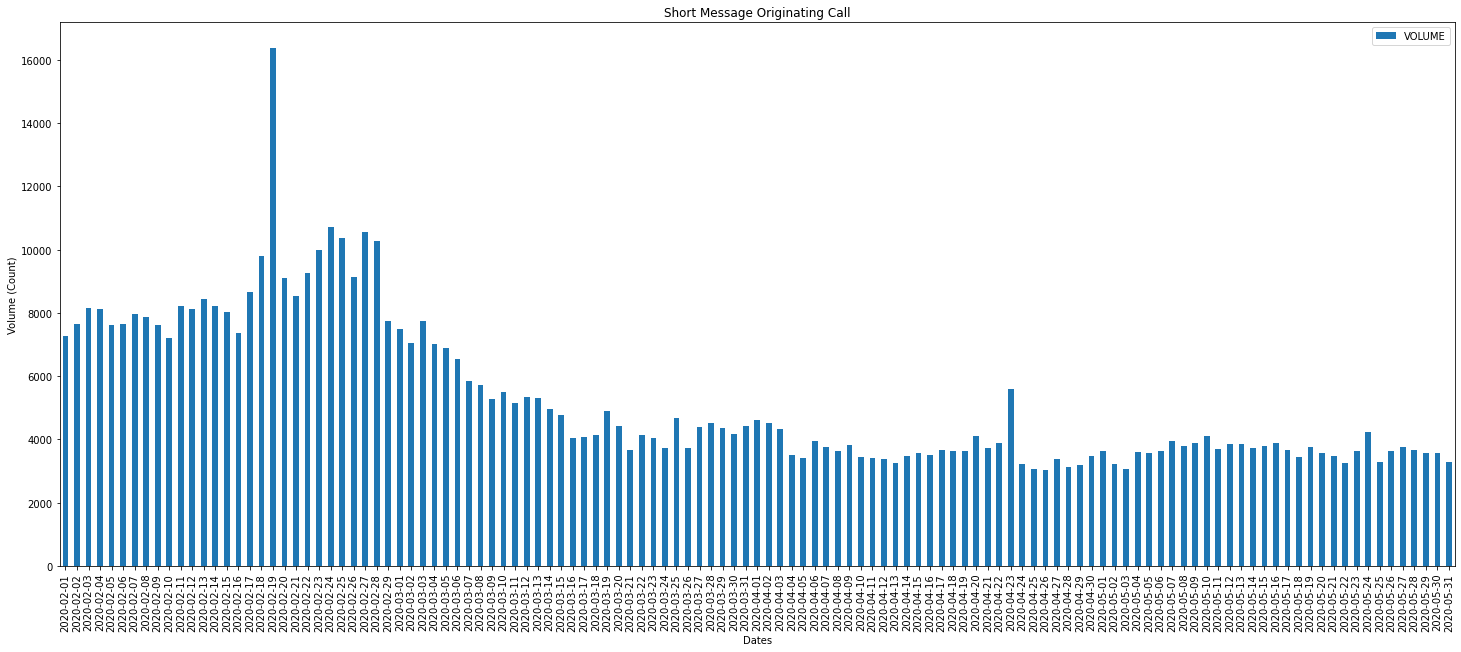

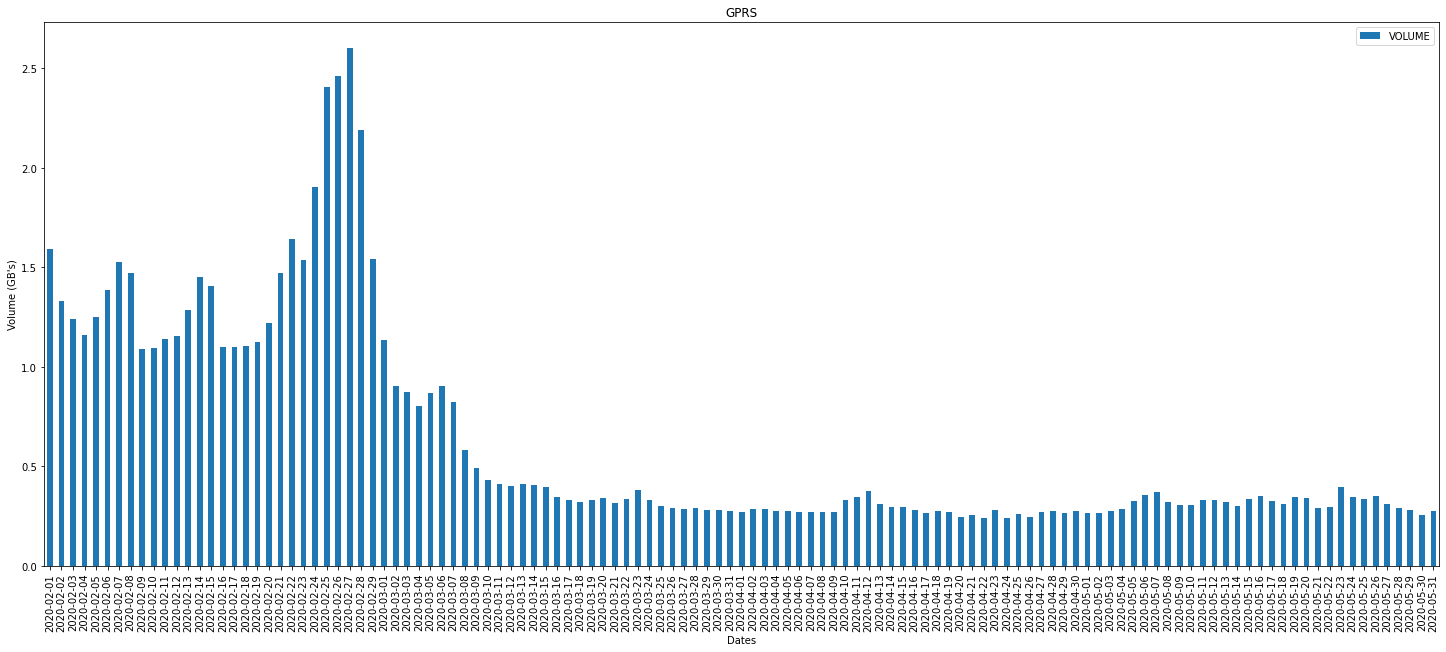

In [63]:
plot_roaming('Mobile originated Call')
plot_roaming('Mobile Terminating Call')
plot_roaming('Short Message Originating Call')
plot_roaming('GPRS')